In [1]:
%matplotlib inline

In [1]:
import torch
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.autonotebook import tqdm
import shutil
import time
from sklearn import metrics

/home/romi/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
im_size=256
mean=0.5
std=0.5
batch_size=16
base_dir='/home/romi/frames2/20 deg 30 cm/'
#base_dir='/content/drive/My Drive/'
valid_percentage=0.2
criterion = nn.CrossEntropyLoss()

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize(size=im_size),
    transforms.RandomCrop(size=im_size), # Image net standards
    transforms.ToTensor(),
    transforms.Normalize((mean, mean, mean), (std, std, std))])
test_transforms = transforms.Compose([
    transforms.Resize(size=im_size),
    transforms.CenterCrop(size=im_size), # Image net standards
    transforms.ToTensor(),
    transforms.Normalize((mean, mean, mean), (std, std, std))])

In [4]:
train_data=torchvision.datasets.ImageFolder(root = base_dir+'train',transform=train_transforms)
test_data=torchvision.datasets.ImageFolder(root = base_dir+'test',transform=test_transforms)
#level2_test_data=torchvision.datasets.ImageFolder(root = base_dir+'level2_test',transform=test_transforms)

In [5]:
train_loader=DataLoader(train_data, batch_size = batch_size , shuffle = True)

train_size=len(train_data)
indices=list(range(train_size))
np.random.shuffle(indices)
split=int(np.floor(valid_percentage*train_size))
train_ids=indices[:split]
valid_ids=indices[split:]
valid_sampler=SubsetRandomSampler(valid_ids)
valid_loader=DataLoader(dataset=train_data,batch_size=batch_size,sampler=valid_sampler)

test_loader=DataLoader(dataset=test_data,batch_size=batch_size)

#level2_test_loader=DataLoader(dataset = level2_test_data,batch_size=batch_size)

In [6]:
classes = train_data.classes
print('No of Classes: ',len(classes))

No of Classes:  6


In [7]:
#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

In [8]:
#inverse normalization for image plot

inv_normalize =  transforms.Normalize(
    mean=(-1*np.divide(mean,std),-1*np.divide(mean,std),-1*np.divide(mean,std)),
    std=(1/std,1/std,1/std)
)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


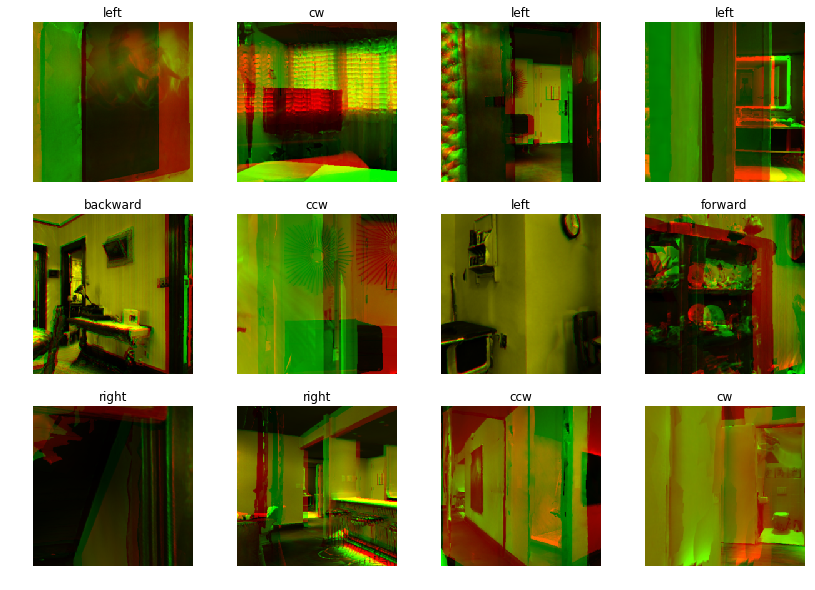

In [9]:
#plotting rondom images from dataset
def class_plot(data , encoder ,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        print(type(image))
        label = int(label)
        l = encoder[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(train_data,encoder,inv_normalize)

In [10]:
class Classifier(nn.Module):
    def __init__(self,n_classes):
        super(Classifier, self).__init__()
        #self.vgg16 = models.vgg16(pretrained = True)
        self.resnet =  models.resnet34(pretrained = True)
        self.l1 = nn.Linear(1000 , 256)
        self.dropout = nn.Dropout(0.5)
        self.l2 = nn.Linear(256,n_classes) # 6 is number of classes
        self.relu = nn.LeakyReLU()
    def forward(self, input):
        x = self.resnet(input)
        x = x.view(x.size(0),-1)
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: ',device)
classifier = Classifier(len(classes)).to(device)
summary(classifier,(3,150,150)) #summary is used to create summary of our model similar to keras summary.

Device:  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          36,864
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
       BasicBlock-11           [-1, 64, 38, 38]               0
           Conv2d-12           [-1, 64, 38, 38]          36,864
      BatchNorm2d-13           [-1, 64, 38, 38]             128
             ReLU-14     

In [11]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        f=open(base_dir+'checkpoint.pt','wb')
        torch.save(model.state_dict(), f)
        f.close()
        self.val_loss_min = val_loss

In [12]:
def train(model,dataloaders,criterion,num_epochs=10,lr=0.00001,batch_size=8,patience = None):
    since = time.time()
    model.to(device)
    best_acc = 0.0
    i = 0
    phase1 = dataloaders.keys()
    losses = list()
    acc = list()
    if(patience!=None):
        earlystop = EarlyStopping(patience = patience,verbose = True)
    for epoch in range(num_epochs):
        print('Epoch:',epoch)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        lr = lr*0.8
        if(epoch%10==0):
            lr = 0.0001

        for phase in phase1:
            if phase == ' train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            total = 0
            j = 0
            for  batch_idx, (data, target) in enumerate(dataloaders[phase]):
                data, target = Variable(data), Variable(target)
                data = data.type(torch.cuda.FloatTensor)
                target = target.type(torch.cuda.LongTensor)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                _, preds = torch.max(output, 1)
                running_corrects = running_corrects + torch.sum(preds == target.data)
                running_loss += loss.item() * data.size(0)
                j = j+1
                if(phase =='train'):
                    loss.backward()
                    optimizer.step()

                if batch_idx % 300 == 0:
                    print('{} Epoch: {}  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'.format(phase,epoch, batch_idx * len(data), len(dataloaders[phase].dataset),100. * batch_idx / len(dataloaders[phase])
                                                                                                 , running_loss/(j*batch_size),running_corrects.double()/(j*batch_size)))
            epoch_acc = running_corrects.double()/(len(dataloaders[phase])*batch_size)
            epoch_loss = running_loss/(len(dataloaders[phase])*batch_size)
            if(phase == 'val'):
                earlystop(epoch_loss,model)

            if(phase == 'train'):
                losses.append(epoch_loss)
                acc.append(epoch_acc)
            print(earlystop.early_stop)
        if(earlystop.early_stop):
            print("Early stopping")
            model.load_state_dict(torch.load(base_dir+'checkpoint.pt'))
            break
        print('{} Accuracy: '.format(phase),epoch_acc.item())
    return losses,acc

In [13]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        classifier.eval()
        output = classifier(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [14]:
def error_plot(loss):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()
def acc_plot(acc):
    plt.figure(figsize=(10,5))
    plt.plot(acc)
    plt.title("Training accuracy plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()
# To plot the wrong predictions given by model
def wrong_plot(n_figures,true,ima,pred,encoder,inv_normalize):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+c + ',' +'P:'+w
        if inv_normalize !=None:
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(f)
        ax.axis('off')
    plt.show()
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

Epoch: 0
train Epoch: 0  [0/48944 (0%)]	Loss: 2.012014 	Acc: 0.062500
train Epoch: 0  [4800/48944 (10%)]	Loss: 1.434823 	Acc: 0.348214
train Epoch: 0  [9600/48944 (20%)]	Loss: 1.324026 	Acc: 0.385399
train Epoch: 0  [14400/48944 (29%)]	Loss: 1.276470 	Acc: 0.408227
train Epoch: 0  [19200/48944 (39%)]	Loss: 1.237014 	Acc: 0.427144
train Epoch: 0  [24000/48944 (49%)]	Loss: 1.197932 	Acc: 0.449575
train Epoch: 0  [28800/48944 (59%)]	Loss: 1.160507 	Acc: 0.473036
train Epoch: 0  [33600/48944 (69%)]	Loss: 1.124513 	Acc: 0.494259
train Epoch: 0  [38400/48944 (78%)]	Loss: 1.088240 	Acc: 0.515280
train Epoch: 0  [43200/48944 (88%)]	Loss: 1.055777 	Acc: 0.532465
train Epoch: 0  [48000/48944 (98%)]	Loss: 1.026351 	Acc: 0.547776
False
val Epoch: 0  [0/48944 (0%)]	Loss: 0.652875 	Acc: 0.750000
val Epoch: 0  [4800/48944 (12%)]	Loss: 0.694611 	Acc: 0.710963
val Epoch: 0  [9600/48944 (25%)]	Loss: 0.687600 	Acc: 0.716098
val Epoch: 0  [14400/48944 (37%)]	Loss: 0.694672 	Acc: 0.712750
val Epoch: 0  [19

val Epoch: 5  [33600/48944 (86%)]	Loss: 0.340018 	Acc: 0.865272
val Epoch: 5  [38400/48944 (98%)]	Loss: 0.339841 	Acc: 0.865421
Validation loss decreased (0.389085 --> 0.340087).  Saving model ...
False
val Accuracy:  0.8650173611111112
Epoch: 6
train Epoch: 6  [0/48944 (0%)]	Loss: 0.325712 	Acc: 0.812500
train Epoch: 6  [4800/48944 (10%)]	Loss: 0.321518 	Acc: 0.875000
train Epoch: 6  [9600/48944 (20%)]	Loss: 0.330634 	Acc: 0.871256
train Epoch: 6  [14400/48944 (29%)]	Loss: 0.325802 	Acc: 0.871670
train Epoch: 6  [19200/48944 (39%)]	Loss: 0.325438 	Acc: 0.871357
train Epoch: 6  [24000/48944 (49%)]	Loss: 0.326673 	Acc: 0.871835
train Epoch: 6  [28800/48944 (59%)]	Loss: 0.325635 	Acc: 0.872501
train Epoch: 6  [33600/48944 (69%)]	Loss: 0.323945 	Acc: 0.873185
train Epoch: 6  [38400/48944 (78%)]	Loss: 0.324052 	Acc: 0.873048
train Epoch: 6  [43200/48944 (88%)]	Loss: 0.321328 	Acc: 0.874630
train Epoch: 6  [48000/48944 (98%)]	Loss: 0.321600 	Acc: 0.874334
False
val Epoch: 6  [0/48944 (0%)]	

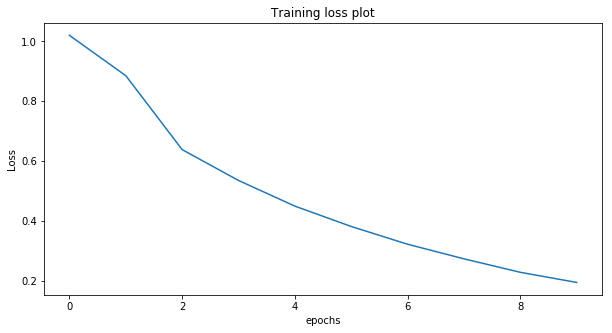

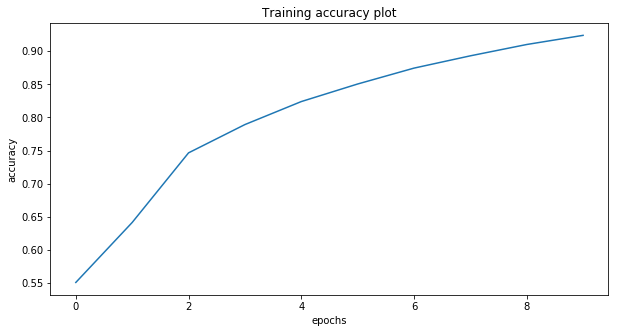

In [15]:
dataloader_train = {}
losses = list()
accuracy = list()
dataloader_train.update([('train',train_loader)])
dataloader_train.update([('val',valid_loader)])
losses,accuracy=train(classifier,dataloader_train,criterion,num_epochs=10,lr=0.00001,batch_size=batch_size,patience=3)
error_plot(losses)
acc_plot(accuracy)

In [15]:
classifier.load_state_dict(torch.load(base_dir+'checkpoint.pt'))

<All keys matched successfully>

In [16]:
true,pred,image,true_wrong,pred_wrong = test(test_loader)

tensor(0.7449, device='cuda:0', dtype=torch.float64) 0.8463001229401864


Classes in order Actual and Predicted


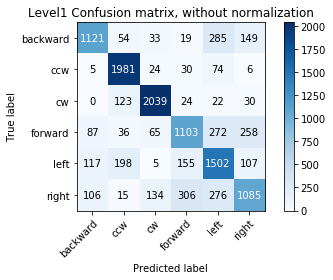

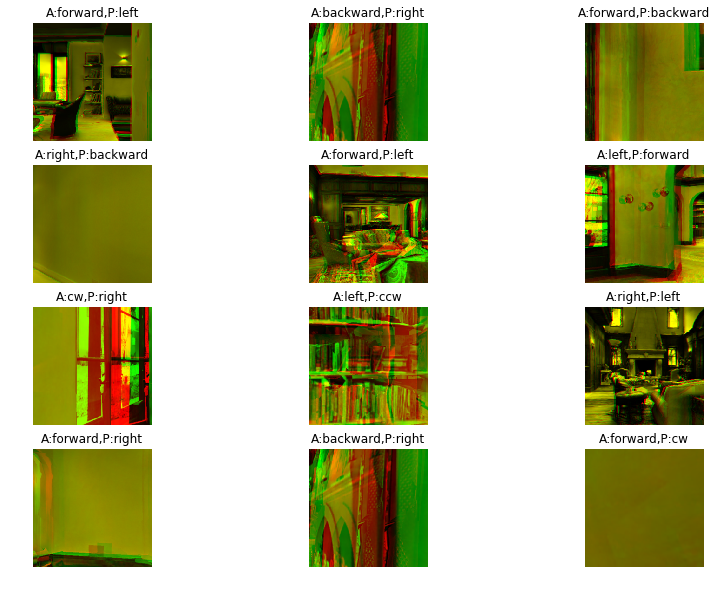

Precision: 74.09055722212366 Recall: 73.52277616686101, Accuracy: 74.5483707580618: ,f1_score: 73.51828091791836
Confusion matrix, without normalization
[[1121   54   33   19  285  149]
 [   5 1981   24   30   74    6]
 [   0  123 2039   24   22   30]
 [  87   36   65 1103  272  258]
 [ 117  198    5  155 1502  107]
 [ 106   15  134  306  276 1085]]


In [18]:
wrong_plot(12,true_wrong,image,pred_wrong,encoder,inv_normalize)
performance_matrix(true,pred)
plot_confusion_matrix(true, pred, classes= classes,title='Level1 Confusion matrix, without normalization')